In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
  return false;
}

<IPython.core.display.Javascript object>

In [2]:
# Modules
import scipy as sp
from scipy import sparse, signal, stats
from astropy import convolution as conv
import numpy as np
from numpy.fft import fft, ifft
import matplotlib.pyplot as plt
from matplotlib import colors as clrs
import pandas as pd 
import time
import datetime
import calendar
import sqlite3
from scipy.optimize import curve_fit

%matplotlib inline 



# Color definitions
ClrS = (0.74, 0.00, 0.00)
ClrN = (0.20, 0.56, 1.00)

Clr = [(0.00, 0.00, 0.00),
      (0.31, 0.24, 0.00),
      (0.43, 0.16, 0.49),
      (0.32, 0.70, 0.30),
      (0.45, 0.70, 0.90),
      (1.00, 0.82, 0.67)]

# Font Size

font = {'family': 'sans-serif',
        'weight': 'normal',
        'size'   : 30}


plt.rc('font', **font)
# plt.rc('text', usetex=True)

In [3]:
# Feature = pd.read_pickle('data/SWAMIS/Features.pnds')
Feature = pd.read_pickle('data\SWAMIS\swamis_0090s_SF.pnds')




CDELT1 = 0.504223
Rs = 968.580444
Rsun = 696000000
DOBS = 148217766833.31

# Converting flux to maxwells
Feature['Flux'] = Feature['Flux']*(CDELT1*Feature['scale'])**2/(np.pi*Rs**2)*2*np.pi*(Rsun*100)**2*Feature['scale']



# Add distance from disk center in arcseconds
Feature['Dis'] = np.sqrt(Feature['xs']**2+Feature['ys']**2)
Feature['Ang'] = -(Feature['Dis']/60/60*np.pi/180- np.arcsin(np.sin(Feature['Dis']/60/60*np.pi/180)*DOBS/Rsun))
Feature['Area'] = 2*np.pi*695**2*Feature['size_s']/(np.pi*Rs**2)*np.divide(1,np.cos(Feature['Ang']))
Feature['meanB'] = np.divide(np.abs(Feature['Flux']),Feature['Area']*100000000**2)


# Feature = Feature[Feature['Life']>1]



# FeatureSF = pd.read_pickle('data\SWAMIS\swamis_0045s_SF.pnds')

# # Converting flux to maxwells
# FeatureSF['Flux'] = FeatureSF['Flux']*(CDELT1*FeatureSF['scale'])**2/(np.pi*Rs**2)*2*np.pi*(Rsun*100)**2*FeatureSF['scale']



# # Add distance from disk center in arcseconds
# FeatureSF['Dis'] = np.sqrt(FeatureSF['xs']**2+FeatureSF['ys']**2)
# FeatureSF['Ang'] = -(FeatureSF['Dis']/60/60*np.pi/180- np.arcsin(np.sin(FeatureSF['Dis']/60/60*np.pi/180)*DOBS/Rsun))

# FeatureSF['Area'] = 2*np.pi*695**2*FeatureSF['size_s']/(np.pi*Rs**2)*np.divide(1,np.cos(FeatureSF['Ang']))
# FeatureSF['meanB'] = np.divide(np.abs(FeatureSF['Flux']),FeatureSF['Area']*100000000**2)


# print(np.max(Feature['Area']))

print(np.min(Feature['Ang'])*180/np.pi)

0.04486575180304076


In [4]:
Feature.head()

,id,Life,scale,Flux,Lat,Lon,x,xerr,y,yerr,MaxSize,xs,ys,size_s,maxB,Dis,Ang,Area,meanB
0,1,9.0,1.0,-4611551925571951104.0,-73.460572,-14.117696,2168.980583,0.287084,3815.946495,0.308943,7.0,-66.316219,-891.486901,1.780222,-114.530262,893.950075,1.171339,4.713507,97.83695
1,2,2.0,1.0,-3264174802590572032.0,-73.246747,-0.797326,2045.085027,0.334994,3812.036092,0.290602,5.0,-3.831130,-889.590302,1.271582,-121.104209,889.598551,1.159847,3.277769,99.585271
2,3,2.0,1.0,-1053532200779089920.0,-73.077809,-0.515724,2042.486745,0.499824,3810.000000,0.000086,2.0,-2.502384,-888.572155,0.508633,-74.707427,888.575678,1.157191,1.303167,80.844011
3,4,1.0,1.0,-1955201473878648832.0,-72.768028,21.967109,1827.657345,0.335591,3809.082584,0.570318,3.0,105.836138,-888.242242,0.762949,-95.060790,894.525331,1.172882,2.027480,96.43507
4,5,1.0,1.0,-1159356393923712256.0,-72.869519,22.617324,1823.000000,0.000022,3810.472332,0.499234,2.0,108.183968,-888.945966,0.508633,-80.192197,895.504719,1.175523,1.360202,85.234132


In [5]:
def trunc_ln(x, si, mu, tr):
    return 1/(x*si*np.sqrt(np.pi))*np.exp(-np.power(np.log(x)-mu,2)/(2*si**2))

def trunc_wb(x, k, l, tr):
     return np.divide(k/l*np.power(x/l,k-1)*np.exp(-np.power(x/l,k)),
                     np.exp(-np.power(tr/l,k)))

class lognorm_weibull(stats.rv_continuous):
    def _argcheck(self, c, si, mu, k, l, tr):
        return (c>=0 and c<=1) and (si > 0) and (l>0) and (k>0) and (tr>0) and (mu>0)
    def _pdf(self, x, c, si, mu, k, l, tr):
            return c*trunc_ln(x, si, mu, tr) + (1-c)*trunc_wb(x, k, l, tr)

class lognorm_tr(stats.rv_continuous):
    def _argcheck(self, si, mu, tr):
        return (si > 0) and (mu>0)
    def _pdf(self, x, si, mu, tr):
            return trunc_ln(x, si, mu, tr)
        
class wb_tr(stats.rv_continuous):
    def _argcheck(self, k, l, tr):
        return (k > 0) and (l>0)
    def _pdf(self, x, k, l, tr):
            return trunc_wb(x, k, l, tr)
    
wbtr = wb_tr()

In [6]:
lntr = lognorm_tr()
lntr.fit(Feature['Area'][Feature['Area']>20], 1, 1, ftr=20, floc=0, fscale=1)

c:\Users\Andres\anaconda3\envs\swamis\Lib\site-packages\scipy\stats\_distn_infrastructure.py:2060: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return integrate.quad(self._pdf, _a, x, args=args)[0]
c:\Users\Andres\anaconda3\envs\swamis\Lib\site-packages\scipy\stats\_distn_infrastructure.py:2788: RuntimeWarning: divide by zero encountered in scalar divide
  Shat = sqrt(mu2hat / mu2)


(0.8087287026703168, 3.9988122242786712, 20, 0, 1)

In [7]:
lnwb = lognorm_weibull()   
    
lnwb.fit(Feature['Area'][Feature['Area']>100], 0.5, 0.9200010390498645, 4.147854097567208, 0.9211678259779241, 103.59611121389516, fc=0.9, fk = 0.6, ftr=20, floc=0, fscale=1)

(0.9, 0.45068708483959236, 5.134746817792582, 0.6, 864.8376149678704, 20, 0, 1)

C:\Users\Andres\AppData\Local\Temp\ipykernel_111836\315576529.py:240: RuntimeWarning: invalid value encountered in divide
  hist_normA = (histout[0]/widthsA[:,None])/histout[0].sum(0)[None,:]


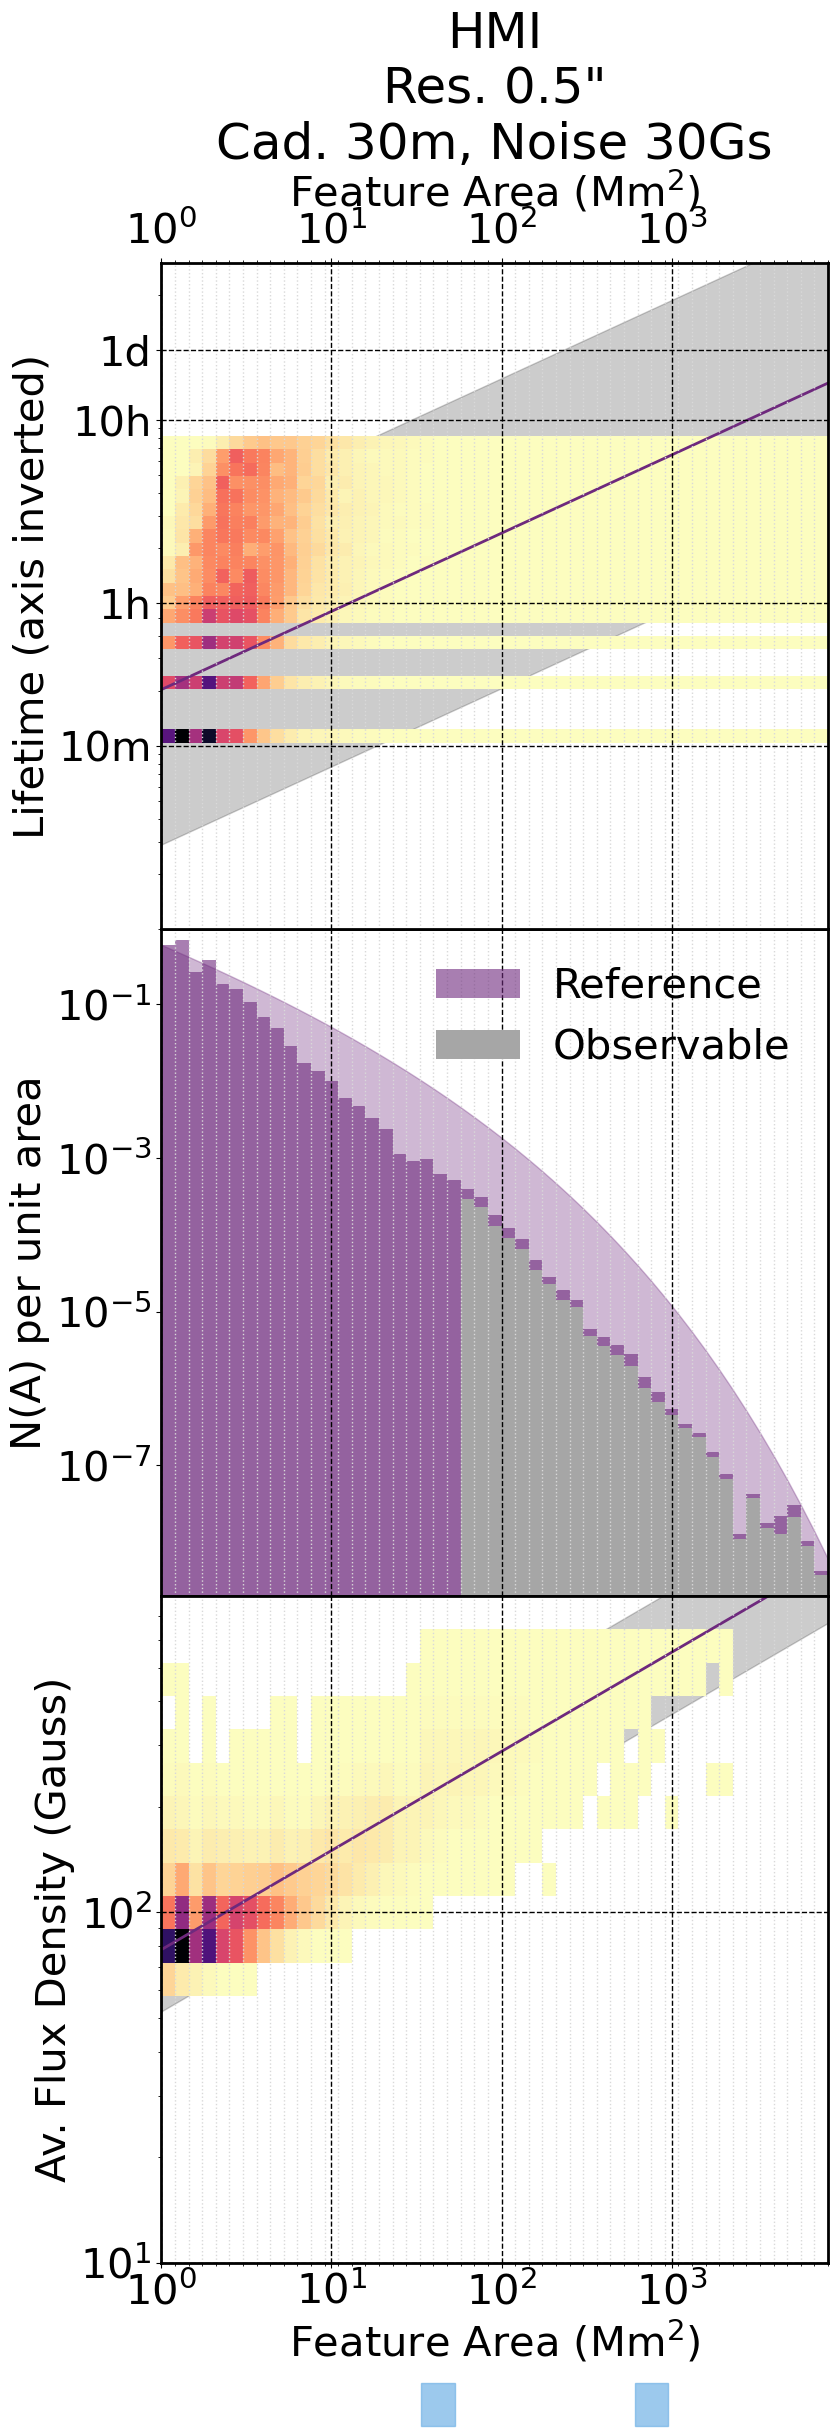

In [8]:
# Distribution Plots for Observer
zorder = 2
baseal = 0.7
delal = 0.4

OrbIn = 7.155

clrgr = (0.85,0.85,0.85)

plt.rc('font', **font)
# plt.rc('text', usetex=True)


# Size definitions
dpi = 300
pxx = 2000   # Horizontal size of each panel
pxy = 2000    # Vertical size of each panel
frc = 1    # Fraction of the panel devoted to histograms

nph = 1      # Number of horizontal panels
npv = 3      # Number of vertical panels

# Padding
padv  = 50 #Vertical padding in pixels
padv2 = 0  #Vertical padding in pixels between panels
padh  = 50 #Horizontal padding in pixels at the edge of the figure
padh2 = 0 #Horizontal padding in pixels between panels

# Figure sizes in pixels
fszv = (npv*pxy + 2*padv + (npv-1)*padv2 )      #Vertical size of figure in inches
fszh = (nph*pxx + 2*padh + (nph-1)*padh2 )      #Horizontal size of figure in inches

# Conversion to relative unites
ppadv  = padv/fszv     #Vertical padding in relative units
ppadv2 = padv2/fszv    #Vertical padding in relative units
ppadh  = padh/fszv     #Horizontal padding the edge of the figure in relative units
ppadh2 = padh2/fszv    #Horizontal padding between panels in relative units


## Start Figure
fig = plt.figure(figsize=(fszh/dpi,fszv/dpi))

###############################################################################################
# HMI
###############################################################################################

OrbIn = 55

# Instrument Definitions
clr = Clr[4]

HMIR = 10
Lat = np.array([60, 55])

# HMIS = HMIR+Lat*0#2*np.pi*695**2*(HMIR*HMIR)/(np.pi*Rs**2)*np.divide(1,np.cos((Lat-OrbIn)*np.pi/180))
HMIS = HMIR*2*np.pi*695**2*(HMIR*HMIR)/(np.pi*Rs**2)*np.divide(1,np.cos((Lat-OrbIn)*np.pi/180))

Noise = 15
HMIN = Noise+Lat*0#*np.divide(1,np.cos((Lat-OrbIn)*np.pi/180))

HMIC = 30/60


HMIR = 0.5*4
Lat = np.array([60, 80])

HMIS = 10*np.divide(1,np.cos((Lat)*np.pi/180))

Noise = 15
HMIN = Noise*np.divide(1,np.cos((Lat-OrbIn)*np.pi/180))

HMIC = 12*2/60


Nbins = 50
A1 = 1
A2 = 1e4
edgesA = np.power(10,np.arange(np.log10(A1),np.log10(A2),(np.log10(A2)-np.log10(A1))/Nbins))

# Distribution of areas
ax1 = fig.add_axes([ppadh, ppadv+pxy/fszv*frc, pxx/fszh*frc, pxy/fszv*frc])


ax1.fill_between(edgesA, wbtr.pdf(edgesA, 0.3018371092212419, 1.71518801820842, 20, 0, 1)/1.5, edgesA*0+2e-9, color=Clr[2], alpha=0.33, zorder = 0)




ax1.hist(Feature['Area'], bins = edgesA, color=Clr[2], alpha=.6, density = True, zorder=1, label='Reference')

# n, bins = np.histogram(Feature['Area'], bins = edgesA)
# Intg = np.multiply(edgesA[1:edgesA.shape[0]]-edgesA[0:edgesA.shape[0]-1],n)
# Dis = np.divide(n,edgesA[1:edgesA.shape[0]]-edgesA[0:edgesA.shape[0]-1])/Feature['Area'].shape[0]
# Corr = 0#np.sum(Intg[edgesA[0:edgesA.shape[0]-1]<=HMIS[-1]])
# ax1.hist(Feature['Area'][np.logical_and(Feature['Area']>HMIS[2], Feature['meanB']>HMIN[2])], bins = edgesA, color=(0.5,0.5,0.5), alpha=1, density = True, zorder=5);

# n, bins = np.histogram(Feature['Area'][np.logical_and(np.logical_and(Feature['Area']>HMIS[0], Feature['meanB']>HMIN[0]),
#                                       (Feature['Life']-1)*12/60>HMIC)], bins = edgesA)
# Dis = np.divide(n,edgesA[1:edgesA.shape[0]]-edgesA[0:edgesA.shape[0]-1])/Feature['Area'].shape[0]
# ax1.bar((edgesA[1:edgesA.shape[0]]+edgesA[0:edgesA.shape[0]-1])/2, Dis, width=(edgesA[1:edgesA.shape[0]]-edgesA[0:edgesA.shape[0]-1]), color=(0.45,0.45,0.45), alpha=1, zorder=zorder)


n, bins = np.histogram(Feature['Area'][np.logical_and(np.logical_and(Feature['Area']>HMIS[-1], Feature['meanB']>HMIN[-1]),
                                      np.logical_or((Feature['Life']-1)*12/60>HMIC, (Feature['Life']-1)*12/60==0))], bins = edgesA)
Dis = np.divide(n,edgesA[1:edgesA.shape[0]]-edgesA[0:edgesA.shape[0]-1])/Feature['Area'].shape[0]
ax1.bar((edgesA[1:edgesA.shape[0]]+edgesA[0:edgesA.shape[0]-1])/2, Dis, width=(edgesA[1:edgesA.shape[0]]-edgesA[0:edgesA.shape[0]-1]), color=(0.65,0.65,0.65), alpha=1, zorder=zorder, label='Observable')


ax1.legend(frameon=False)

# s, loc, scale = stats.lognorm.fit(Feature['Area'])
# print(s,loc,scale)
# ax1.plot(edgesA, stats.lognorm.pdf(edgesA, s, loc, scale), 'r-', lw=5, alpha=0.6, label='lognorm pdf')

# # Plot transparency mask
# for i in np.arange(0,HMIS.shape[0]):
#     if i==0:
#         x1 = np.min(edgesA)
#     else:
#         x1 = HMIS[i-1]
#     alphamsk = baseal-delal*i    
#     ax1.fill([x1, x1, HMIS[i], HMIS[i]], [1e-9, 1, 1, 1e-9], color=clr, alpha = alphamsk, zorder=zorder, edgecolor = 'none')

# s, loc, scale = stats.lognorm.fit(Feature['Area'][Feature['Area']>100],floc=10)
# print(s,loc,scale)
# ax1.plot(edgesA, stats.lognorm.pdf(edgesA, s, loc, scale), 'r-', lw=5, alpha=0.6, label='lognorm pdf')

# s, loc, scale = stats.dweibull.fit(Feature['Area'][Feature['Area']>100])
# ax1.plot(edgesA, stats.dweibull.pdf(edgesA, s, loc, scale), 'r-', lw=5, alpha=0.6, label='dweibull pdf')
# ax1.plot(edgesA, lnwb.pdf(edgesA,0.9, 0.5313502050630872, 5.373345960266665, 0.6, 725.4904206531216, 20), lw=5, alpha=0.6, label='lognorm pdf')

# ax1.plot(edgesA, lntr.pdf(edgesA, 0.9200010390498645, 4.147854097567208, 20), lw=5, alpha=0.6, label='lognorm pdf')
# ax1.plot(edgesA, wbtr.pdf(edgesA, 0.3018371092212419, 1.71518801820842, 20, 0, 1)/1.5, lw=2, color=Clr[2], alpha=1, zorder = zorder+0.2)

ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlim(left = np.min(edgesA), right = np.max(edgesA))

ax1.set_ylim(bottom = 2e-9, top = 0.95)
ax1.set_ylabel('N(A) per unit area')

ax1.grid(color=clrgr, linestyle=':', linewidth=1, axis='x', which='minor')
ax1.grid(color='k', linestyle='--', linewidth=1, axis='x', which='major')
ax1.minorticks_on()
ax1.set_xticks(edgesA, minor=True)
ax1.set_xticklabels([], minor=True);
ax1.set_xticklabels([])


Nbins = 20

B1 = 10
B2 = 800
edgesB = np.power(10,np.arange(np.log10(B1),np.log10(B2),(np.log10(B2)-np.log10(B1))/Nbins))


# Scatter Plot
ax2 = fig.add_axes([ppadh, ppadv, pxx/fszh*frc, pxy/fszv*frc])
ax2.hist2d(Feature['Area'], Feature['meanB'], bins = [edgesA,edgesB], cmap=plt.cm.magma_r,cmin=1)
# ax1.scatter(Feature['Area'], np.divide(np.abs(Feature['Flux']),Feature['Area']*100000000**2)*Feature['scale'])

def fit_func(x, a, b):
    return a*np.power(x,b)

params = curve_fit(fit_func, Feature['Area'].values.astype(float), np.divide(np.abs(Feature['Flux']),Feature['Area']*100000000**2).values.astype(float))
[a, b] = params[0]
ax2.plot(edgesA, fit_func(edgesA, a, b), lw=2, color=Clr[2], alpha=1)


ax2.fill_between(edgesA, fit_func(edgesA, a, b)/1.5, fit_func(edgesA, a, b)*1.5, color='k', alpha=0.2, zorder = 0)


# for i in np.arange(0,HMIS.shape[0]):
#     alphamsk = baseal-delal*i
#     if i==0:
#         ax2.fill([np.min(edgesA), np.min(edgesA), HMIS[i], HMIS[i], np.max(edgesA), np.max(edgesA)], [B1, B2, B2, HMIN[i], HMIN[i], B1], color=clr, alpha = alphamsk, zorder=zorder, edgecolor = 'none')
#     else:
#         ax2.fill([HMIS[i-1], HMIS[i-1], HMIS[i], HMIS[i], np.max(edgesA), np.max(edgesA)], [HMIN[i-1], B2, B2, HMIN[i], HMIN[i], HMIN[i-1]], color=clr, alpha = alphamsk, zorder=zorder, edgecolor = 'none')
        
        
ypos1 = -0.18
ypos2 = -0.245

xpos1 = 0 
xpos2 = 0.05

totshift = -0.1

shift = 0.49 + totshift
ax2.fill([xpos1+shift, xpos1+shift, xpos2+shift, xpos2+shift], [ypos1, ypos2, ypos2, ypos1], color=clr, alpha = baseal, zorder=zorder, clip_on = False, transform=ax2.transAxes)           

shift = 0.81 + totshift
ax2.fill([xpos1+shift, xpos1+shift, xpos2+shift, xpos2+shift], [ypos1, ypos2, ypos2, ypos1], color=clr, alpha = baseal, zorder=zorder, clip_on = False, transform=ax2.transAxes)           

# ax2.text(totshift, -0.25, 'Not visible for:     $\beta < 60^o$     $\beta < 80^o$', horizontalalignment='left', verticalalignment='bottom',transform=ax2.transAxes)


ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_ylim(bottom = B1, top = B2);
ax2.set_xlim(left = np.min(edgesA), right = np.max(edgesA))

ax2.set_xlabel('Feature Area (Mm$^2$)')
ax2.grid(color=clrgr, linestyle=':', linewidth=1, axis='x', which='minor')
ax2.grid(color='k', linestyle='--', linewidth=1, axis='x', which='major')
ax2.minorticks_on()
ax2.set_xticks(edgesA, minor=True)
ax2.set_xticklabels([], minor=True);

ax2.set_yticks([20, 30, 40, 50, 60, 70, 80, 90, 200, 300, 400, 500, 600, 700], minor=True)
# ax2.set_yticklabels(['', '', '', 50, '', '', '', '', '', '', '', 500, '', ''] , minor=True, fontdict= {'fontsize':15})
ax2.set_yticklabels([] , minor=True, fontdict= {'fontsize':15})
ax2.grid(color='k', linestyle='--', linewidth=1, axis='y', which='major')

ax2.set_ylabel('Av. Flux Density (Gauss)')


Nbins = 50

T1 = 1/60
T2 = 72
# edgesT = np.arange(T1,T2)
edgesT = np.power(10,np.arange(np.log10(T1),np.log10(T2),(np.log10(T2)-np.log10(T1))/Nbins))


# Scatter Plot
ax3 = fig.add_axes([ppadh, ppadv+2*pxy/fszv*frc, pxx/fszh*frc, pxy/fszv*frc])

# histout = ax3.hist2d(Feature['Area'], (Feature['Life']-1)*12/60, bins = [edgesA,edgesT], cmap=plt.cm.viridis_r, cmin=1.22e-9, density=True)
# ax3.scatter(Feature['Area'], Feature['Life']*12/60)

histout = np.histogram2d(Feature['Area'], (Feature['Life']-1)*12/60, bins = [edgesA,edgesT])


widthsT = edgesT[1:]-edgesT[0:-1]
hist_normT = (histout[0]/widthsT[None,:])/histout[0].sum(1)[:,None]


widthsA = edgesA[1:]-edgesA[0:-1]
hist_normA = (histout[0]/widthsA[:,None])/histout[0].sum(0)[None,:]

# hist_normA[histout[0]<=2] = np.nan


ax3.pcolormesh(edgesA, edgesT, hist_normA.T, cmap=plt.cm.magma_r)


params = curve_fit(fit_func, Feature['Area'].values.astype(float), (Feature['Life'].values.astype(float)-1)*12/60, method='lm')
[a, b] = params[0]
ax3.plot(edgesA, fit_func(edgesA, a, b), lw=2, color=Clr[2], alpha=1)


ax3.fill_between(edgesA, fit_func(edgesA, a, b)/7, fit_func(edgesA, a, b)*7, color='k', alpha=0.2, zorder = 0)


# # Plot transparency mask
# for i in np.arange(0,HMIS.shape[0]):
#     alphamsk = baseal-delal*i
#     if i==0:
#         ax3.fill([np.min(edgesA), np.min(edgesA), HMIS[i], HMIS[i], np.max(edgesA), np.max(edgesA)], [T1, T2, T2, HMIC, HMIC, T1], color=clr, alpha = alphamsk, zorder=zorder, edgecolor = 'none')
#     else:
#         ax3.fill([HMIS[i-1], HMIS[i-1], HMIS[i], HMIS[i]], [HMIC, T2, T2, HMIC], color=clr, alpha = alphamsk, zorder=zorder, edgecolor = 'none')


ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.set_ylim(bottom = T1, top = T2);
ax3.set_xlim(left = np.min(edgesA), right = np.max(edgesA))
# ax3.set_xticklabels([])

ax3.set_xlabel('Feature Area (Mm$^2$)')
ax3.set_ylabel('Lifetime (axis inverted)')


ax3.grid(color=clrgr, linestyle=':', linewidth=1, axis='x', which='minor')
ax3.grid(color='k', linestyle='--', linewidth=1, axis='x', which='major')
ax3.xaxis.tick_top()
ax3.minorticks_on()
ax3.set_xticks(edgesA, minor=True)
ax3.set_xticklabels([], minor=True);
ax3.xaxis.set_label_position('top')

ax3.set_yticks([10/60, 1, 10, 24], minor=False)
ax3.set_yticklabels(['10m', '1h', '10h', '1d'] , minor=False)
ax3.set_title('HMI\nRes. 0.5\"\nCad. 30m, Noise 30Gs')

ax3.set_yticks([1/60, 2/60, 3/60, 4/60, 5/60, 6/60, 7/60, 8/60, 9/60, 20/60, 30/60, 40/60, 50/60, 2, 3, 4, 5, 6, 7, 8, 9, 48], minor=True)
# ax3.set_yticklabels(['1m', '2m', '', '', '5m', '', '', '', '', '20m', '', '40m', '', '2h', '', '', '5h', '', '', '', '', '2d'] , minor=True, fontdict= {'fontsize':15});
ax3.set_yticklabels([] , minor=True, fontdict= {'fontsize':15});
ax3.grid(color='k', linestyle='--', linewidth=1, axis='y', which='major')

# ax3.invert_yaxis()

for k, spine in ax1.spines.items():  #ax.spines is a dictionary
    spine.set_zorder(10)
    spine.set_linewidth(2)
    
for k, spine in ax2.spines.items():  #ax.spines is a dictionary
    spine.set_zorder(10)
    spine.set_linewidth(2)
    
for k, spine in ax3.spines.items():  #ax.spines is a dictionary
    spine.set_zorder(10) 
    spine.set_linewidth(2)
    
ax1.set_axisbelow(False)
ax2.set_axisbelow(False)
ax3.set_axisbelow(False)
